# Data Project - Danish uemployment and COVID19
### Introduction to Programming and Numerical Analysis

**University of Copenhagen, 11 April 2021**

Hand-in by Magnus Bugge, Jens Brøndum Petersen, and Frederik Bach

This project investigates how the gross unemployment rates of different Danish industries have been affected by the Covid-19 crisis and its resulting economic drawdown. Specifically we compare data from three Danish unemployment insurance funds (3F, Akademikernes a-kasse and Børne- og Ungdomspædagoger (BUPL-A)) using data from the Statistics Denmark API. Then, we combine the unemployment data with Covid-19 hospitalization numbers. The analysis concludes that, in our sample, the workers belonging to 3F have been affected mostly relative to the other chosen groups. This could be due to the higher degree of labor demand elasticity in the sectors employing workers of lower education levels. 

We start the analysis by importing modules:

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader

import datetime

import pydst # import of the Statistics Denmark API wrapper
dst = pydst.Dst(lang='en') # changing the language to English for API lookups

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

We now import data which describes the development in the unemployment rate of different industries. We check which table subjects we need from DST:

In [3]:
dst.get_subjects() # obtaining all top level categories from DST

,id,desc,active,hasSubjects
0,02,Population and elections,True,True
1,04,"Labour, income and wealth",True,True
2,06,Prices and consumption,True,True
3,05,Living conditions,True,True
4,14,National accounts and government finances,True,True
5,03,Education and knowledge,True,True
6,11,Business sectors,True,True
7,07,Business sector in general,True,True
8,16,Money and credit market,True,True
9,13,External economy,True,True


We see that ID = 04 seems relevant for our analysis. More specifically, we need the AUF02 table. Now, we inspect that table to see what variables it contains:

In [4]:
tables = dst.get_tables()
tables.loc[tables['id'] == 'AUF02'] # obtaining information about the AUF02 table 

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
277,AUF02,Unemployed persons,number,2021-03-31 08:00:00,2007M01,2020M08,True,"[region, type of benefits, unemployment insura..."


We need the region, and other relevant variables. We need to find out how to sort the data import. To this end, we need the variable ID's for the variables we will base the sort on.

In [5]:
indk_vars = dst.get_variables(table_id='AUF02')

# for loop which prints all ID's and explanatory names
for id in ['OMRÅDE','AKASSE','KØN']: 
    print(id)
    values = indk_vars.loc[indk_vars.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

OMRÅDE
 id = 000, text = All Denmark
 id = 084, text = Region Hovedstaden
 id = 01, text = Province Byen København
 id = 101, text = Copenhagen
 id = 147, text = Frederiksberg
 id = 155, text = Dragør
 id = 185, text = Tårnby
 id = 02, text = Province Københavns omegn
 id = 165, text = Albertslund
 id = 151, text = Ballerup
 id = 153, text = Brøndby
 id = 157, text = Gentofte
 id = 159, text = Gladsaxe
 id = 161, text = Glostrup
 id = 163, text = Herlev
 id = 167, text = Hvidovre
 id = 169, text = Høje-Taastrup
 id = 183, text = Ishøj
 id = 173, text = Lyngby-Taarbæk
 id = 175, text = Rødovre
 id = 187, text = Vallensbæk
 id = 03, text = Province Nordsjælland
 id = 201, text = Allerød
 id = 240, text = Egedal
 id = 210, text = Fredensborg
 id = 250, text = Frederikssund
 id = 190, text = Furesø
 id = 270, text = Gribskov
 id = 260, text = Halsnæs
 id = 217, text = Helsingør
 id = 219, text = Hillerød
 id = 223, text = Hørsholm
 id = 230, text = Rudersdal
 id = 04, text = Province Bornh

We choose data from three different unemployment insurance funds: 3F, Akademikernes a-kasse and Børne- og Ungdomspædagoger (BUPL-A). We choose these three funds as the members are employed in different industries with different labor demand and supply dynamics.

As the first case of Covid-19 was discovered in Denmark in March 2020, we choose to start the data series in January 2020. The last data point in the table AUF02 is August 2020.

In [9]:
AUF02 = dst.get_data(table_id = 'AUF02', variables={'OMRÅDE':['000'], 'AKASSE':['48','43','05'], 'KØN':['TOT'], 'TID':['2020M01', '2020M02', '2020M03', '2020M04', '2020M05', '2020M06', '2020M07', '2020M08']})
AUF02 = AUF02.loc[AUF02['TID'] != '2007M01'] # define the API lookup

AUF02_pivot = AUF02.pivot(index='TID', columns='AKASSE', values='INDHOLD') # create a pivot table such that all unemployment funds get their own column

AUF02_pivot.reset_index(level=0, inplace=True)
AUF02_pivot["TID"].replace({"2020M01": "January, 2020", "2020M02": "February, 2020", "2020M03": "March, 2020", "2020M04": "April, 2020", "2020M05": "May, 2020", "2020M06": "June, 2020", "2020M07": "July, 2020", "2020M08": "August, 2020"}, inplace=True)

AUF02_pivot.columns.name = AUF02_pivot.index.name
AUF02_pivot.index.name = None

AUF02_pivot.head(8) # print entire table (only 8 rows!)

,TID,Akademikernes (fra 1. juli 2013 inkl. ingeniører),Børne- og Ungdomspædagoger (BUPL-A),Faglig Fælles a-kasse (3F)
0,"January, 2020",10236,2048,16150
1,"February, 2020",10558,2138,15817
2,"March, 2020",10775,2023,17588
3,"April, 2020",11687,2099,20209
4,"May, 2020",12258,2011,19501
5,"June, 2020",12734,2403,17295
6,"July, 2020",14564,2742,14281
7,"August, 2020",14454,2381,13526


We will now download some COVID statistics. In this case, we will use the table SMIT1 from DST. Again we need the variable IDs for the variables we will base the sort on:

In [6]:
SMIT1_vars = dst.get_variables(table_id='SMIT1')
SMIT1_vars
 

for id in ['AKTP']:
    print(id)
    values = SMIT1_vars.loc[SMIT1_vars.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

AKTP
 id = 10, text = Confirmed cases of COVID-19 (total)
 id = 15, text = Recovered from COVID-19 infection (total)(02.04.2020 -)
 id = 18, text = Number of Covid-19 tests (total) (20.05.2020 -)
 id = 20, text = Number of persons tested for COVID-19 (total)
 id = 25, text = Deaths with COVID-19 (total)
 id = 30, text = Deaths with COVID-19 per day
 id = 35, text = Persons hospitalised in connection with COVID-19
 id = 40, text = Patients in intensive care units in connection with COVID-19
 id = 45, text = Patients on ventilators in connection with COVID-19


As a proxy for the prevalence of Covid-19 we use data for the number of hospitalized due to the virus. SMIT1 is calculated on a daily basis and in order to compare these data with the data from AUF02 we assign the first observation in each month to that month. As the first cases of Covid were discovered in January 2020 the SMIt1 data from DST starts in this month. Therefore, we add two datapoints for January and February - in both month the number of hospitalized were obviously 0.

In [10]:
SMIT1 = dst.get_data(table_id = 'SMIT1', variables={'AKTP':['35'], 'TID':['2020M04D01', '2020M05D01', '2020M06D01', '2020M07D01', '2020M08D03']})

# create zero value rows for hospitalizations before Covid-19 hit Denmark
NewRowsJan = pd.DataFrame({'AKTP':'Indlagte på sygehusene ifm. COVID-19', 'TID':'2020M01', 'INDHOLD':0}, index=[0]) 
NewRowsFeb = pd.DataFrame({'AKTP':'Indlagte på sygehusene ifm. COVID-19', 'TID':'2020M02', 'INDHOLD':0}, index=[0])

SMIT1= pd.concat([NewRowsJan, NewRowsFeb, SMIT1]).reset_index(drop = True)

SMIT1["TID"].replace({"2020M01": "January, 2020", "2020M02": "February, 2020", "2020M03D21": "March, 2020", "2020M04D01": "April, 2020", "2020M05D01": "May, 2020", "2020M06D01": "June, 2020", "2020M07D01": "July, 2020", "2020M08D03": "August, 2020"}, inplace=True)

SMIT1.set_index("TID")

SMIT1

,AKTP,TID,INDHOLD
0,Indlagte på sygehusene ifm. COVID-19,"January, 2020",0
1,Indlagte på sygehusene ifm. COVID-19,"February, 2020",0
2,Persons hospitalised in connection with COVID-19,"March, 2020",206
3,Persons hospitalised in connection with COVID-19,"April, 2020",535
4,Persons hospitalised in connection with COVID-19,"May, 2020",229
5,Persons hospitalised in connection with COVID-19,"June, 2020",88
6,Persons hospitalised in connection with COVID-19,"July, 2020",29
7,Persons hospitalised in connection with COVID-19,"August, 2020",24


We now delete the column 'AKTP' and change the name of the column "Indhold". Next, we merge the two tables.

In [13]:
del SMIT1["AKTP"]

# rename the column
SMIT1=SMIT1.rename(columns={"INDHOLD":"Indlagte på sygehusene ifm. COVID-19"})

# now, join AUF02 and SMIT1 on the TID column
AUF02_SMIT1 = pd.merge(AUF02_pivot, SMIT1, on = "TID")
AUF02_SMIT1.head(10)

KeyError: 'AKTP'

Now, to make the data on the three unemployment funds comparable, we index the data, such that January 2020 = 100. 

In [9]:
for column in ['Faglig Fælles a-kasse (3F)', 'Børne- og Ungdomspædagoger (BUPL-A)', 'Akademikernes (fra 1. juli 2013 inkl. ingeniører)']:
        AUF02_SMIT1[column] = AUF02_SMIT1[column].div(AUF02_SMIT1[column].iloc[0])*100
        
AUF02_SMIT1 = AUF02_SMIT1.rename(columns = {"Akademikernes (fra 1. juli 2013 inkl. ingeniører)": "Akademikernes A-kasse"})
        
AUF02_SMIT1.head(10)

,TID,Akademikernes A-kasse,Børne- og Ungdomspædagoger (BUPL-A),Faglig Fælles a-kasse (3F),Indlagte på sygehusene ifm. COVID-19
0,"January, 2020",100.000000,100.000000,100.000000,0
1,"February, 2020",103.145760,104.394531,97.938080,0
2,"March, 2020",105.265729,98.779297,108.904025,206
3,"April, 2020",114.175459,102.490234,125.133127,535
4,"May, 2020",119.753810,98.193359,120.749226,229
5,"June, 2020",124.404064,117.333984,107.089783,88
6,"July, 2020",142.282141,133.886719,88.427245,29
7,"August, 2020",141.207503,116.259766,83.752322,24


Now, we plot the data using the matplotlib package.

<Figure size 432x288 with 0 Axes>

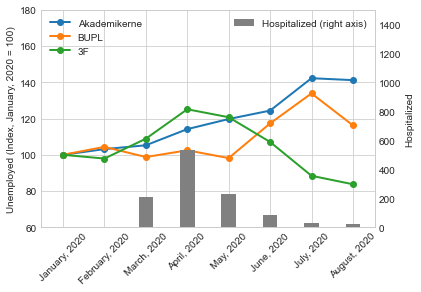

In [10]:
# Using matplotlib to visualize the data obtained, starting out with making a line chart
fig = plt.figure()
ax = AUF02_SMIT1.iloc[:, [1,2,3]].plot(use_index=True, linestyle='-', marker='o', linewidth=2.0)

# Rotating the ticks on the x-axis 45 degrees
plt.xticks(rotation=45)
plt.legend(['Akademikerne', 'BUPL', '3F'], loc = 2)

# Adding a secondary y-axis for the same x-axis
ax2 = ax.twinx()

# Combining the first chart with a bar chart
ax2.bar(AUF02_SMIT1.iloc[:, 0], AUF02_SMIT1.iloc[:, 4].values, data=AUF02_SMIT1, color='gray',width=0.35,label='NE',zorder=0)
ax2.grid(None)

# Setting the labels for the two y-axis
ax.set_ylabel('Unemployed (Index, January, 2020 = 100)')
ax2.set_ylabel('Hospitalized')

# Modifying the two y-axis to give a clearer visual of correlation.
ax.set_ylim([60, 180])
ax2.set_ylim([0, 1500])

plt.legend(['Hospitalized (right axis)'], loc = 1)
plt.show()

The main insight from the figure above, and the analysis in general, is that the workers belonging to 3F (mostly industrial workers) were the ones being hit mostly in the beginning of the crisis, implying a low degree of labour hoarding for this group. Conversely, the workers belonging to Akademikernes A-kasse (university graduates), experienced a more gradual increase in gross unemployment, suggesting a high degree of labour hoarding. Moreover, the industrial workers experienced a boom in employment during the late spring and early summer of 2020, also suggesting that there is a high degree of elasticity in labour demand for this group.

## add GFC data for exam hand-in